--- Starting RIDGE REGRESSION Model Training Workflow ---
Engineering features...
VERIFICATION: Number of features selected for training: 37
Scaling features...
VERIFICATION: Shape of scaled training data: (7192, 37)
Scaling complete.

--- 5. Training a Ridge Regression Model ---
Model training complete.
VERIFICATION: Model was trained on 37 features.

--- 6. Validation Set Performance Analysis ---


/var/folders/st/8z9yjrgn4fq_j2pyt73wn7d00000gn/T/ipykernel_23069/1504524254.py:43: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_train = pd.read_csv(TRAIN_FILE_PATH, parse_dates=['date_id']).sort_values('date_id')


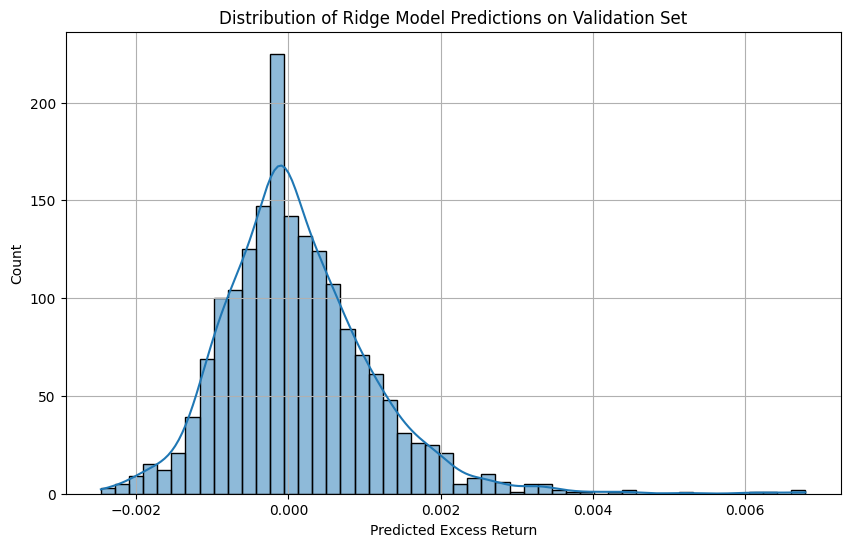

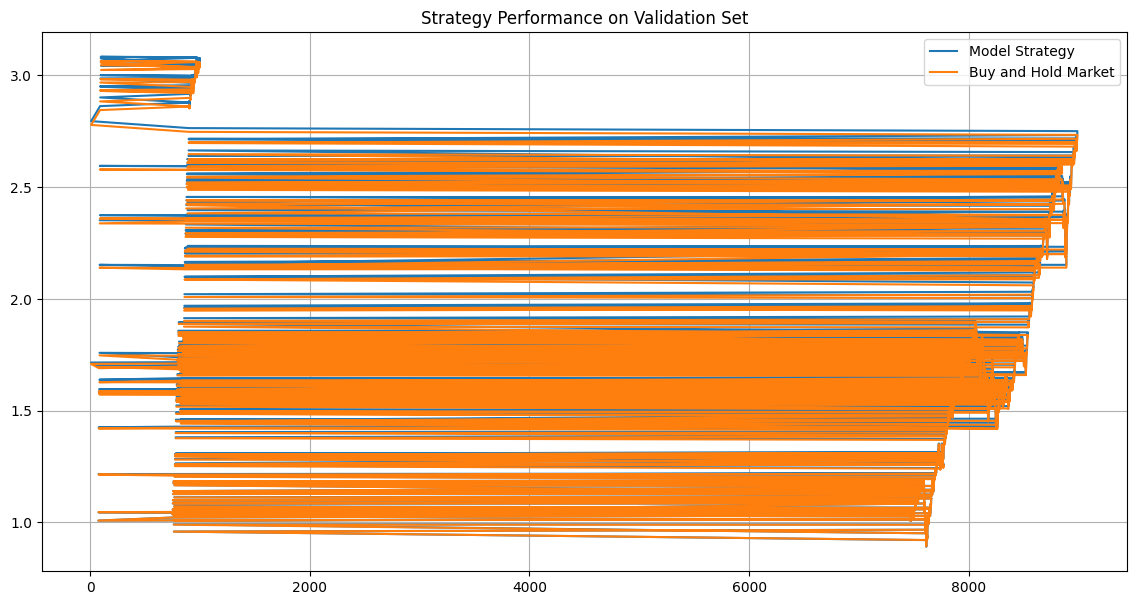


--- 7. Saving Final Model, Scaler, and Features ---
Saving final model to: /Users/rushilpatel/Downloads/hull-tactical-market-prediction/ridge_model.pkl
Saving scaler to: /Users/rushilpatel/Downloads/hull-tactical-market-prediction/scaler.pkl
Saving feature list with 37 features to: /Users/rushilpatel/Downloads/hull-tactical-market-prediction/selected_features.txt

--- Workflow Finished Successfully! ---


In [26]:
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
import pickle
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np

# --- Configuration ---
# IMPORTANT: Make sure these paths are correct for your local setup.
DATA_PATH = '/Users/rushilpatel/Downloads/hull-tactical-market-prediction/'
OUTPUT_PATH = '/Users/rushilpatel/Downloads/hull-tactical-market-prediction/'

TRAIN_FILE_PATH = os.path.join(DATA_PATH, 'train.csv')
MODEL_OUTPUT_PATH = os.path.join(OUTPUT_PATH, 'ridge_model.pkl')
SCALER_OUTPUT_PATH = os.path.join(OUTPUT_PATH, 'scaler.pkl')
FEATURES_OUTPUT_PATH = os.path.join(OUTPUT_PATH, 'selected_features.txt')
DAYS_PER_YEAR = 252

# This scaling factor MUST match the one in your submission script.
ALLOCATION_SCALING_FACTOR = 7.0

# --- Feature Engineering ---
def engineer_features(df):
    df = df.copy()
    print("Engineering features...")
    
    df['P1_div_V1'] = df['P1'] / (df['V1'] + 1e-6)
    df['I1_mul_E1'] = df['I1'] * df['E1']
    lags = [1, 5, 21]
    features_to_lag = ['M1', 'V1', 'P1', 'S1']
    for feature in features_to_lag:
        for lag in lags:
            df[f'{feature}_lag_{lag}'] = df[feature].shift(lag)
            
    return df

def train_and_evaluate_model():
    print("--- Starting RIDGE REGRESSION Model Training Workflow ---")

    df_train = pd.read_csv(TRAIN_FILE_PATH, parse_dates=['date_id']).sort_values('date_id')

    base_features = [
        'M1', 'M5', 'M6', 'E1', 'E5', 'E7', 'I1', 'I5', 'I7',
        'P1', 'P5', 'P6', 'V1', 'V5', 'V8', 'V9',
        'S1', 'S5', 'S8', 'S10', 'D1', 'D5', 'D8'
    ]
    target = 'market_forward_excess_returns'
    
    df_train_engineered = engineer_features(df_train)
    
    engineered_feature_names = ['P1_div_V1', 'I1_mul_E1'] + [f'{f}_lag_{l}' for f in ['M1', 'V1', 'P1', 'S1'] for l in [1, 5, 21]]
    final_features = base_features + engineered_feature_names

    df_train_engineered.dropna(subset=[target], inplace=True)
    
    X = df_train_engineered[final_features].ffill().bfill()
    y = df_train_engineered[target]
    
    print(f"VERIFICATION: Number of features selected for training: {len(X.columns)}")

    # --- Train/Validation Split ---
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

    # --- SCALING (CRITICAL FOR LINEAR MODELS) ---
    print("Scaling features...")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    print(f"VERIFICATION: Shape of scaled training data: {X_train_scaled.shape}")
    print("Scaling complete.")

    # --- Model Training: Ridge Regressor ---
    print("\n--- 5. Training a Ridge Regression Model ---")
    ridge = Ridge(alpha=10.0, random_state=42)
    ridge.fit(X_train_scaled, y_train)
    print("Model training complete.")
    print(f"VERIFICATION: Model was trained on {ridge.n_features_in_} features.")

    # --- 6. Validation Analysis ---
    print("\n--- 6. Validation Set Performance Analysis ---")
    y_pred_val = ridge.predict(X_val_scaled)

    plt.figure(figsize=(10, 6))
    sns.histplot(y_pred_val, bins=50, kde=True)
    plt.title('Distribution of Ridge Model Predictions on Validation Set')
    plt.xlabel('Predicted Excess Return')
    plt.grid(True)
    plt.show()

    val_results_df = df_train_engineered.loc[X_val.index].copy()
    val_results_df['prediction'] = y_pred_val
    positions = np.clip(1.0 + val_results_df['prediction'] * ALLOCATION_SCALING_FACTOR, 0, 2)
    val_results_df['strategy_return'] = val_results_df['risk_free_rate'] * (1 - positions) + positions * val_results_df['forward_returns']
    val_results_df['cumulative_strategy'] = (1 + val_results_df['strategy_return']).cumprod()
    val_results_df['cumulative_market'] = (1 + val_results_df['forward_returns']).cumprod()

    plt.figure(figsize=(14, 7))
    plt.plot(val_results_df['cumulative_strategy'], label='Model Strategy')
    plt.plot(val_results_df['cumulative_market'], label='Buy and Hold Market')
    plt.title('Strategy Performance on Validation Set')
    plt.legend()
    plt.grid(True)
    plt.show()

    # --- 7. Save Final Artifacts ---
    print("\n--- 7. Saving Final Model, Scaler, and Features ---")
    
    print(f"Saving final model to: {MODEL_OUTPUT_PATH}")
    with open(MODEL_OUTPUT_PATH, 'wb') as f:
        pickle.dump(ridge, f)
    
    print(f"Saving scaler to: {SCALER_OUTPUT_PATH}")
    with open(SCALER_OUTPUT_PATH, 'wb') as f:
        pickle.dump(scaler, f)
        
    print(f"Saving feature list with {len(X.columns)} features to: {FEATURES_OUTPUT_PATH}")
    with open(FEATURES_OUTPUT_PATH, 'w') as f:
        for feature in X.columns:
            f.write(f"{feature}\n")
            
    print("\n--- Workflow Finished Successfully! ---")


if __name__ == '__main__':
    if not os.path.exists(OUTPUT_PATH):
        os.makedirs(OUTPUT_PATH)
    train_and_evaluate_model()

